In [14]:
!pip install tensorflow==2.15
import tensorflow as tf
from huggingface_hub import hf_hub_download

In [15]:
file_path = hf_hub_download(repo_id="shylhy/cnn-keras-deepfake-subset", filename="deepfake_detector_cnn.h5")

In [16]:
model = tf.keras.models.load_model(file_path)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import backend as K

In [19]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array / 255


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the output with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, 0]

    # Calculate gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Mean intensity of the gradient over specific feature map channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    # Weigh each channel in the feature map array by the importance of this channel for the class prediction
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [20]:
import math
def closest_factors(n):
    # Start with the square root of n
    m = int(math.sqrt(n))

    # Loop to find the closest factors
    while n % m != 0:
        m -= 1  # Decrement m if it doesn't divide n

    k = n // m  # Compute the corresponding factor k
    return m, k

In [21]:
import tensorflow.keras as keras

## Obviously Deepfaked

In [22]:
def plot_heatmaps(img_path, model, d={1: "deepfake", 0: "real"}):
    img_array = (get_img_array(img_path, size=(224, 224)))
    p = model.predict(img_array)
    print(f"Model predicts class {d[round(p.item())]} with confidence {p.item()}")
    hms = []
    conv = []
    cnt = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            cnt+=1
            conv.append(layer.name)
            hms.append(make_gradcam_heatmap(img_array, model, layer.name))

    # Plot all heatmaps
    fig, axes = plt.subplots(*closest_factors(cnt), figsize=(20, 12))  # Adjust grid size based on number of images (3x5 grid for 15)
    for i, ax in enumerate(axes.flat):
        ax.matshow(hms[i], cmap='plasma')
        ax.axis('off')  # Turn off axis for better visualization
        ax.set_title(f"Heatmap {i+1} for layer {conv[i]}")

    plt.tight_layout()
    plt.show()

In [23]:
model.predict(get_img_array("frame_0008_adgb_deepfake.jpg", size=(224,224)))


1/1 [==============================] - 0s 68ms/step


array([[0.9541921]], dtype=float32)

1/1 [==============================] - 0s 20ms/step
Model predicts class deepfake with confidence 0.9541921019554138


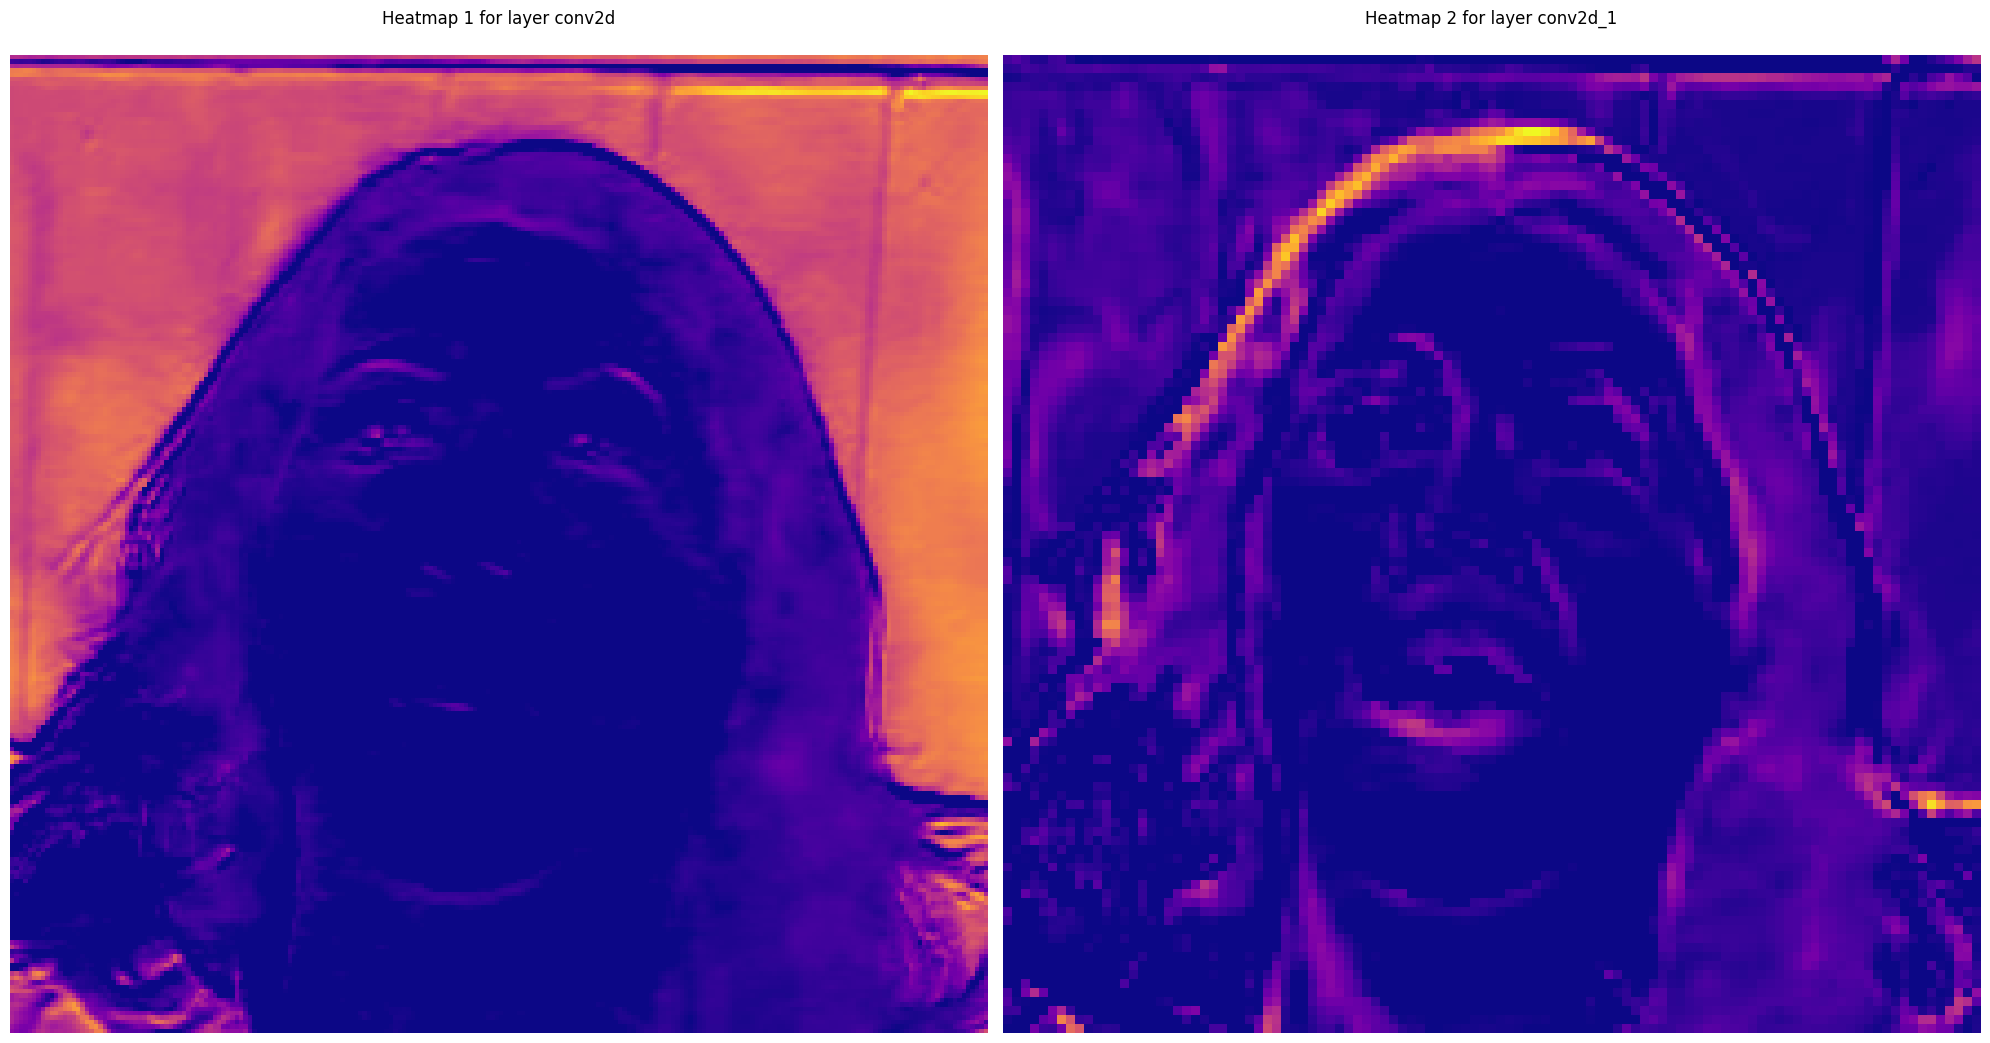

In [24]:
plot_heatmaps("frame_0008_adgb_deepfake.jpg", model)

## Real Images


1/1 [==============================] - 0s 22ms/step
Model predicts class real with confidence 2.3292006972042145e-06


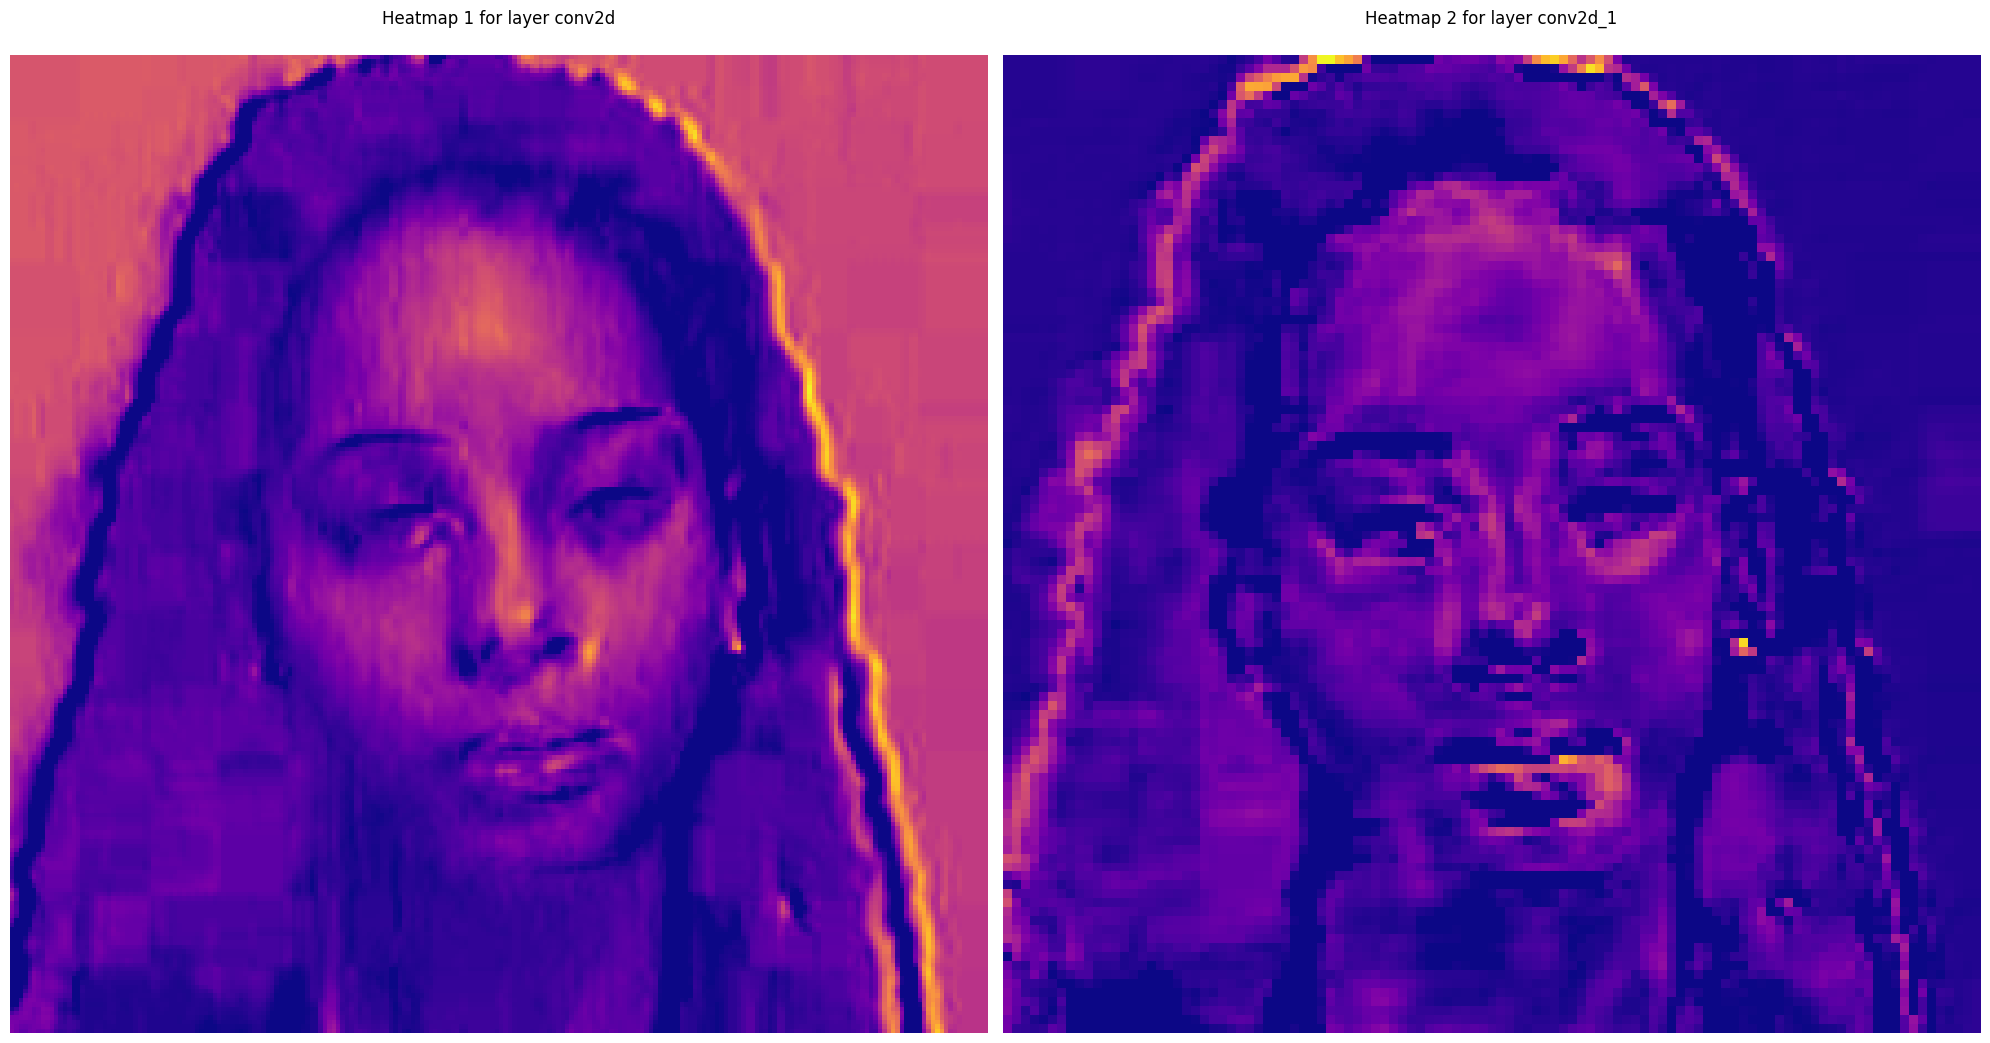

In [25]:
plot_heatmaps("frame_0028_afbg_real.jpg", model)